# Tarea 6 - Jose Adrian Castillo Sierra - 1664207

Para la realizacion de esta tarea se realiza la clasificacion de vegetales utilizando 3 tecnicas diferentes con el fin de poder comparar las tecnicas y resultados obtenidos

## Arquitectura basada en AlexNet

In [1]:
import os

import tensorflow as tf
from tensorflow import keras
import argparse
from imutils import paths
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import glob

from tensorflow.keras import backend as K
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
import seaborn as sns

Primero definimos algunos constantes como los tamaños de las imagenes, epochs y directorio base de las imagenes

In [2]:
Hg = 150
Lng = 150

INIT_LR = 0
BS = 16
EPOCHS = 20

BASE_DIR = '.\\Vegetable Images'

Utilizando ImageDataGenerator de keras cargamos los datos de entrenamiento y de validacion

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_directory(BASE_DIR + '\\train', target_size=(Hg, Lng), batch_size=BS, seed=42, class_mode='categorical')

Found 15001 images belonging to 15 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen_flow = test_datagen.flow_from_directory(BASE_DIR + '\\test', target_size=(Hg, Lng), batch_size=BS, seed=42, class_mode='categorical')

Found 3000 images belonging to 15 classes.


Definimos una arquitectura de Red Neuronal con base a la de Alexnet

In [5]:
model = Sequential()
model.add(Conv2D(15, (11, 11), input_shape=(Lng, Hg, 3),
        padding='same', kernel_regularizer=l2(INIT_LR)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(36, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(15))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

In [6]:
model.compile(loss='categorical_crossentropy', metrics=['acc', 'AUC'], optimizer='adam')
H = model.fit(train_datagen_flow, validation_data=test_datagen_flow, steps_per_epoch=len(train_datagen_flow), 
          validation_steps=len(test_datagen_flow), epochs=EPOCHS, verbose=2)

model.save('model.h5')

Epoch 1/20
938/938 - 43s - loss: 1.4287 - acc: 0.5776 - auc: 0.9213 - val_loss: 1.3004 - val_acc: 0.6127 - val_auc: 0.9174 - 43s/epoch - 45ms/step
Epoch 2/20
938/938 - 31s - loss: 0.8831 - acc: 0.7545 - auc: 0.9674 - val_loss: 0.7442 - val_acc: 0.7763 - val_auc: 0.9737 - 31s/epoch - 33ms/step
Epoch 3/20
938/938 - 31s - loss: 0.6747 - acc: 0.8161 - auc: 0.9739 - val_loss: 1.1243 - val_acc: 0.6903 - val_auc: 0.9236 - 31s/epoch - 33ms/step
Epoch 4/20
938/938 - 30s - loss: 0.5378 - acc: 0.8589 - auc: 0.9730 - val_loss: 0.6050 - val_acc: 0.8187 - val_auc: 0.9556 - 30s/epoch - 32ms/step
Epoch 5/20
938/938 - 31s - loss: 0.4453 - acc: 0.8868 - auc: 0.9686 - val_loss: 0.3915 - val_acc: 0.8913 - val_auc: 0.9654 - 31s/epoch - 33ms/step
Epoch 6/20
938/938 - 31s - loss: 0.3601 - acc: 0.9144 - auc: 0.9682 - val_loss: 0.4028 - val_acc: 0.8817 - val_auc: 0.9539 - 31s/epoch - 33ms/step
Epoch 7/20
938/938 - 31s - loss: 0.3055 - acc: 0.9283 - auc: 0.9665 - val_loss: 0.7453 - val_acc: 0.7680 - val_auc: 0.

Mostramos las curvas de precision y de perdida a lo largo de los epochs.

Algo que se puede notar es como poco a poco el acurracy va en aumento al igual que la perdida se reduce.

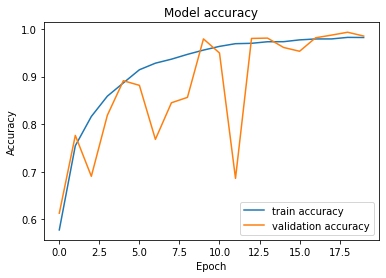

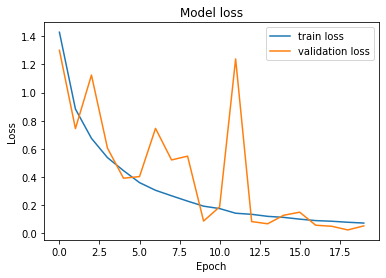

In [7]:
def plot_accuracy(history):
    
    plt.plot(history.history['acc'],label='train accuracy')
    plt.plot(history.history['val_acc'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(H)
plot_loss(H)

In [8]:
K.clear_session()
path_to_model='./model.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


En base al modelo generado vamos a compararlo con los datos de validacion. Para esto leeremos las imagenes de validacion y finalmente veremos el resultado final en una matriz de confusion.

In [9]:
validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    BASE_DIR + '\\validation',
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 3000 images belonging to 15 classes.


C:\Users\Adrian\AppData\Local\Temp\ipykernel_22952\662446566.py:9: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(validation_generator)


Test Accuracy: 0.982


In [10]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(150, 150))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('\\')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(150, 150))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
                
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

In [11]:
validation_folder = BASE_DIR + '\\validation'
for i in os.listdir(validation_folder):
    predict_dir(os.path.join(validation_folder,i),model)

Accuracy for Bean: 0.99 (199/200)
Accuracy for Bitter_Gourd: 0.97 (195/200)
Accuracy for Bottle_Gourd: 1.00 (200/200)
Accuracy for Brinjal: 0.98 (197/200)
Accuracy for Broccoli: 0.98 (197/200)
Accuracy for Cabbage: 0.99 (199/200)
Accuracy for Capsicum: 0.99 (199/200)
Accuracy for Carrot: 1.00 (200/200)
Accuracy for Cauliflower: 0.95 (191/200)
Accuracy for Cucumber: 0.97 (194/200)
Accuracy for Papaya: 0.97 (195/200)
Accuracy for Potato: 0.99 (199/200)
Accuracy for Pumpkin: 0.93 (185/200)
Accuracy for Radish: 1.00 (200/200)
Accuracy for Tomato: 0.97 (195/200)


In [12]:
def labels_confusion_matrix(validation_folder):
    
    folder_path=validation_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('\\')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(150,150))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 15
    cmap="turbo"
    cm_plot_labels = [i for i in range(15)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [13]:
y_true,y_pred=labels_confusion_matrix(validation_folder)

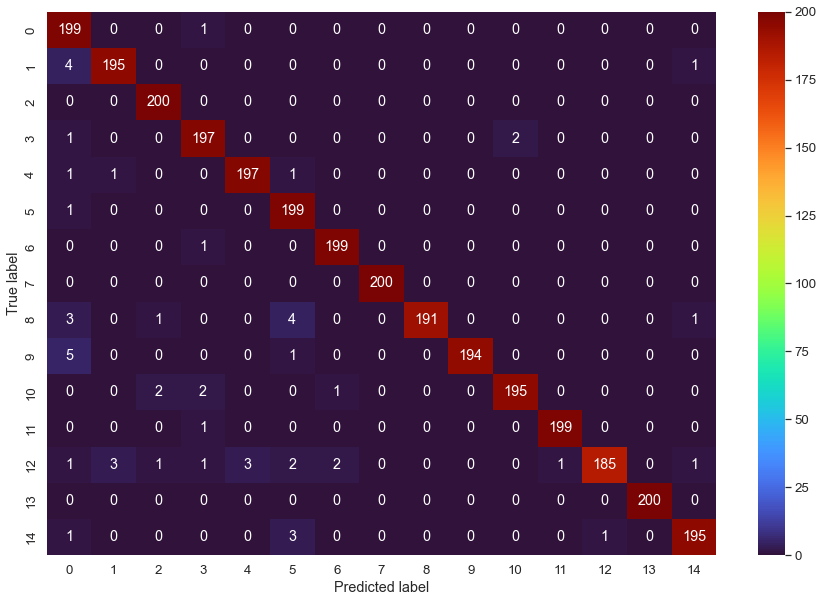

In [14]:
print_confusion_matrix(y_true,y_pred)

In [15]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

np.count_nonzero(y_pred == y_true) / len(y_pred)

0.9816666666666667

In [16]:
## Arquitectua diferente pero con modificadores de imagenes